## Importing Libraries

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

## Importing Dataset

In [9]:
df = pd.read_csv("spam.csv")
df.rename(columns={"Category":"label","Message":"text"}, inplace=True)
df["label_num"] = df["label"].map({"ham":0,"spam":1})
df.head()

,label,text,label_num
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


## Naive Bayes (from scratch)

In [10]:
class MultinomialNBFromScratch:
    def __init__(self, alpha=1.0):
        self.alpha = alpha

    def fit(self, X, y):
        self.classes = np.unique(y)
        self.class_priors = {}
        self.likelihoods = {}
        n_docs, n_features = X.shape

        for c in self.classes:
            X_c = X[y==c]
            self.class_priors[c] = np.log(X_c.shape[0]/n_docs)
            word_count = X_c.sum(axis=0)
            total = word_count.sum()
            self.likelihoods[c] = np.log((word_count + self.alpha) / (total + self.alpha * n_features))

    def predict(self, X):
        preds = []
        for x in X:
            class_scores = {}
            for c in self.classes:
                class_scores[c] = self.class_priors[c] + (x * self.likelihoods[c]).sum()
            preds.append(max(class_scores, key=class_scores.get))
        return np.array(preds)


## Evaluation

In [11]:
def evaluate_model(vectorizer):
    X = vectorizer.fit_transform(df['text']).toarray()
    y = df['label_num'].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    nb = MultinomialNBFromScratch(alpha=1.0)
    nb.fit(X_train, y_train)
    y_pred = nb.predict(X_test)
    return {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

results = {}
for name, vec in [('Count', CountVectorizer()), ('TF-IDF', TfidfVectorizer())]:
    results[name] = evaluate_model(vec)
results


{'Count': {'accuracy': 0.9856502242152466,
  'precision': 0.9403973509933775,
  'recall': 0.9530201342281879,
  'f1': 0.9466666666666667,
  'confusion_matrix': array([[957,   9],
         [  7, 142]])},
 'TF-IDF': {'accuracy': 0.9650224215246637,
  'precision': 1.0,
  'recall': 0.738255033557047,
  'f1': 0.8494208494208494,
  'confusion_matrix': array([[966,   0],
         [ 39, 110]])}}

## Confusion Matrices

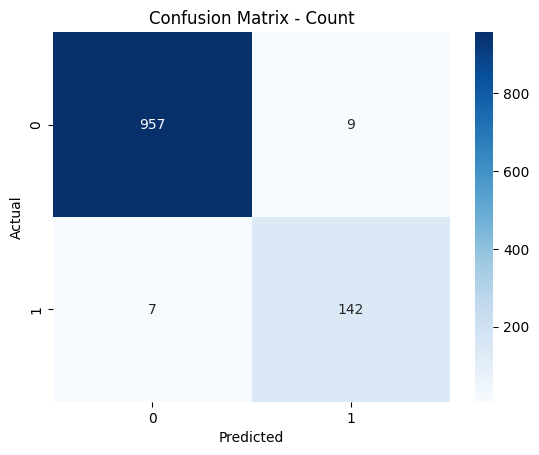

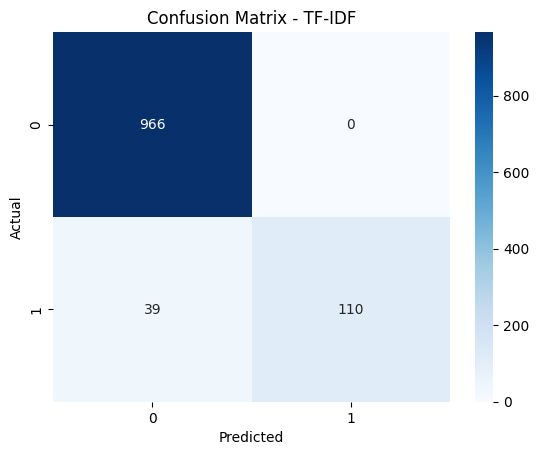

In [13]:
for name, res in results.items():
    sns.heatmap(res['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f'result {name}')
    plt.show()
    


## Results Table

In [14]:
summary = pd.DataFrame([{
    'Model': 'Naive Bayes (Scratch)',
    'Vectorizer': name,
    'Accuracy': f"{res['accuracy']:.2f}",
    'Precision': f"{res['precision']:.2f}",
    'Recall': f"{res['recall']:.2f}",
    'F1': f"{res['f1']:.2f}"
} for name,res in results.items()])
summary


,Model,Vectorizer,Accuracy,Precision,Recall,F1
0,Naive Bayes (Scratch),Count,0.99,0.94,0.95,0.95
1,Naive Bayes (Scratch),TF-IDF,0.97,1.00,0.74,0.85
